# Infinite Horizon LQR control problem solved with Deep Learning and Dynamic Programming

In [2]:
import numpy as np                                                                                                                    
import torch
import torch.nn as nn
from abc import abstractmethod, ABC 
import tqdm
import matplotlib.pyplot as plt

### Vectorized functions for Linear drift and quadratic running cost

These functions are vectorized so that they can be applied to a batch of data

In [3]:
class Func(ABC):                                                                                                                                                                                                                                                               

    def __init__(self):
        pass
    
    @abstractmethod
    def __call__(self, x, *kwargs):
        ... 

    @abstractmethod
    def dx(self, x, **kwargs):
        """ 
        gradient
        """
        ... 

# Linear function, vectorized so that it can be calculated on a batch of data
class Drift_linear(Func):                                                                                                                                                                                                                                                      

    def __init__(self, L, M): 
        """ 
        Parameters
        ----------
        L: torch.Tensor
            Tensor of shape (d,d)
        M: torch.Tensor
            Tensor of shape (d,d)
        """
        self.L=L
        self.M=M

    def __call__(self, x, a): 
        """Returns Lx + Ma
        Parameters
        ----------
        t: torch.Tensor
            time. Tensor of shape (batch_size, 1)
        x: torch.Tensor
            State. Tensor of shape (batch_size, dim)
        a: torch.Tensor
            Action. Tensor of shape (batch_size, dim)
        
        Returns
        -------
        drift: torch.Tensor
            Tensor of shape (batch_size, dim)
        
        """
        Lx = torch.matmul(self.L, x.unsqueeze(2)) # (batch_size, d, 1)
        Ma = torch.matmul(self.M, a.unsqueeze(2)) # (batch_size, d, 1)
        return (Lx+Ma).squeeze(2) # (batch_size, d)

    def dx(self, x, a): 
        pass

# Quadratic running cost, vectorized so that it can be calculated on a batch of data
class QuadraticRunningCost(Func):
                                                                                                                                                                                                                                                                               
    def __init__(self, C, D, F):
        """
        Parameters
        ----------
        C: torch.Tensor
            Tensor of shape (d,d)
        D: torch.Tensor
            Tensor of shape (d,d)
        F: torch.Tensor
            Tensor of shape (d,d)
        """
        self.C = C
        self.D = D
        self.F = F

    def __call__(self, x, a):
        """
        Calculate x.T*C*x + a.T*D*a + 2*x.T*F*a
        Parameters
        ----------
        x: torch.Tensor
            tensor of shape (batch_size, d)
        a: torch.Tensor
            tensor of shape (batch_size, d)
        """
        Cx = torch.matmul(self.C, x.unsqueeze(2)) # (batch_size, d, 1)
        xCx = torch.bmm(x.unsqueeze(1),Cx) # (batch_size, 1, 1)
        Da = torch.matmul(self.D, a.unsqueeze(2)) # (batch_size, d, 1)
        aDa = torch.bmm(a.unsqueeze(1),Da) # (batch_size, 1, 1)
        Fa = torch.matmul(self.F, a.unsqueeze(2)) # (batch_size, d, 1)
        xFa = torch.bmm(x.unsqueeze(1),Fa) # (batch_size, 1, 1)
        return (xCx + aDa + 2*xFa).squeeze(2) # (batch_size, 1)

    def dx(self,x):
        pass

### Feedforward NN

In [4]:
class FFN(nn.Module):
                                                                                                                                                                                                                                                                               
    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity):
        super().__init__()

        layers = []
        for j in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[j-1], sizes[j]))
            if j<(len(sizes)-1):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def forward(self, *args):
        x = torch.cat(args, -1) 
        return self.net(x)

# LQR problem

$ X_{n+1} = x_{n} + \left(L\cdot x_n + \int M\cdot a\, \pi(da)\right)\tau + \sigma \Delta W$

$v(x) = E^{x,t} \left[\sum_{n=0}^{\infty} \delta^n \int f(X_n^\pi, a) \pi(X_n^\pi, da) | X_0=x \right]$




In [5]:
class LQR():
    
    def __init__(self, d: int, discount_factor: float, tau: float, sigma: float = 1., device = 'cpu', **kwargs):

        """LQR model
        dX_t = (L(t)*X_t + M(t)*alpha_t)dt + sigma_t dW_t
        
        J(t,x) = E^{t,x} [ \sum_{n=0}^\infty \delta^n  C(s) X_s^2 + D(s) alpha_s^2 ]
        
        Parameters
        ----------
        d: int
            dimension of state. I assum dim of state and dim of action and dim of Brownian motion are the same for simplicity
        discount_factor: float
            Discount factor in Bellman equation between (0,1)
        tau: float
            Change of time, in time discretisation
        sigma: float
            Diffusion in LQR SDE. I assume the diffusion is constant. Can be easily changed
        device: str
            Device where things are run
            
        
        """
        self.d = d # dimension of the LQR. I assume dimesnion of state and dimension of action are equal
        
        # Parameters of LQR (diffusion is constant)
        self.L = torch.zeros(d, d).to(device)
        self.M = torch.eye(d).to(device)
        self.C = torch.eye(d, d).to(device)
        self.D = torch.eye(d).to(device)
        self.F = torch.zeros(d, d).to(device)
        self.R = torch.eye(d).to(device)
        self.sigma = sigma

        # Drfit of LQR. 
        self.drift = Drift_linear(self.L, self.M)
        
        # Running cost of LQR
        self.f = QuadraticRunningCost(self.C, self.D, self.F)
        
        # time discretisation
        self.tau = tau
        
        # policy
        self.alpha = FFN(sizes = [self.d + 1] + kwargs['hidden_dims'] + [self.d]) # input of alpha is (x,z) where z is input noise
        self.optimizer_alpha = torch.optim.RMSprop(self.alpha.parameters(), lr=0.001)
        self.scheduler_alpha = torch.optim.lr_scheduler.MultiStepLR(self.optimizer_alpha, milestones=[1000], gamma=0.1)
        
        # value function
        self.v = FFN(sizes = [self.d] + kwargs['hidden_dims'] + [1]) # input of v is x
        self.optimizer_v = torch.optim.RMSprop(self.v.parameters(), lr=0.001)
        self.scheduler_v = torch.optim.lr_scheduler.MultiStepLR(self.optimizer_v, milestones=[1000], gamma=0.1)
        
        # discount factor for Bellman equation
        self.discount_factor = discount_factor
        
        
    def _step(self, x: torch.Tensor, n_mc: int):
        """
        Performs one step of euler scheme
        x_next = x + drift(x,a) * dt + diffusion * dW_t
        
        Parameters
        ----------
        x: torch.Tensor
            tensor. tensor of shape (N_batch, d)
        
        n_mc: int
            Number of monte carlo samples to approximate drift
        
        Returns
        -------
        bellman_loss: torch.Tensor
            bellman loss: ( v(x) - 1/N_mc \sum(f + delta * v(x_next)) )^2
        
        bellman_approx: torch.Tensor
            bellman approximation of v(x): 1/N_mc \sum(f + delta * v(x_next))
        
        """
        n_batch = x.shape[0]
        # MONTE CARLO!
        x_mc = torch.repeat_interleave(x, n_mc, dim=0) # (n_mc * n_batch, d)
        z = torch.randn(n_mc*n_batch, 1, device=x.device) # input noise for the policy generator
        a = self.alpha(x_mc, z)
        
        # Euler step
        dW = torch.randn_like(x_mc) * np.sqrt(self.tau)
        x_next = x_mc + self.drift(x_mc, a) * self.tau + self.sigma * dW # Euler step. x_next has shape (n_batch * n_mc, d)
        
        # running cost
        running_cost = self.f(x_mc, a) # (n_batch * n_mc, 1)
        
        # bellman approx
        bellman_approx = running_cost + self.discount_factor * self.v(x_next) # (n_batch*n_mc, 1)
        bellman_approx = bellman_approx.reshape(n_batch, n_mc, -1).mean(1) # (n_batch, 1)
        
        # bellman loss
        bellman_loss = torch.pow(self.v(x) - bellman_approx.detach(),2).mean()
        return bellman_loss, bellman_approx.mean()
    
    def update_alpha(self, n_batch, n_mc):
        """
        Gradient descent on alpha
        """
        
        toggle(self.v, to=False)
        toggle(self.alpha, to=True)
        
        #x0 = torch.randn(n_batch, self.d)
        x0 = sample_x0(n_batch, self.d)
        self.optimizer_alpha.zero_grad()
        _, bellman_approx = self._step(x0, n_mc)
        bellman_approx.backward()
        self.optimizer_alpha.step()
        self.scheduler_alpha.step()
        return bellman_approx.detach()
    
    def update_v(self, n_batch, n_mc):
        """
        Gradient descent on v
        """
        
        toggle(self.v, to=True)
        toggle(self.alpha, to=False)
        
        #x0 = torch.randn(n_batch, self.d)
        x0 = sample_x0(n_batch, self.d)
        self.optimizer_v.zero_grad()
        bellman_loss, _ = self._step(x0, n_mc)
        bellman_loss.backward()
        self.optimizer_v.step()
        self.scheduler_v.step()
        return bellman_loss.detach()

## Auxiliary functions 
- Sampling function for $x_0$. I sample $x_0$ from a uniform in [-10,10]. 
- freezeing / unfreezing networks' parameters


In [5]:
def sample_x0(batch_size, dim, device='cpu', ):
    #sigma = 0.3
    #mu = 0.08
    #tau = 0.1
    #z = torch.randn(batch_size, dim, device=device)
    #x0 = torch.exp((mu-0.5*sigma**2)*tau + 0.3*np.sqrt(tau)*z) # lognormal
    x0 = -10 + 20*torch.rand(batch_size, dim, device=device)
    return x0

# freeze / unfreeze networks' parameters
def toggle(net: nn.Module,  to: bool):
    for p in net.parameters():
        p.requires_grad_(to)

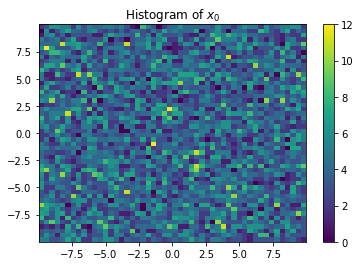

In [6]:
x0 = sample_x0(10000, dim=2).numpy()
plt.hist2d(x0[:,0], x0[:,1], bins=50)
plt.colorbar()
plt.title(r'Histogram of $x_0$')
plt.show()

## Learning

In [7]:
d = 2  # dimension of the process
sigma = 1. # diffusion                                                                                                            
discount_factor = 0.8
tau = 2 # time discretisation step length

# learning hyperparameters
n_batch = 200
n_mc = 200
hidden_dims = [20,20]
n_updates_alpha = 10
n_updates_v = 10
max_updates = 1000

lqr = LQR(d=d, sigma=sigma, discount_factor=discount_factor, tau=tau, hidden_dims=hidden_dims )

# learning
pbar = tqdm.tqdm(total = max_updates)
count = 0
bellman_loss = []
bellman_approx = []
while count < max_updates:
    for i in range(n_updates_alpha):
        v_approx = lqr.update_alpha(n_batch = n_batch, n_mc = n_mc)
        bellman_approx.append(v_approx)
        #pbar.update(1)
    #pbar.write('Bellman approx: {:1.2e}'.format(v_approx))
    for i in range(n_updates_v):
        loss = lqr.update_v(n_batch = n_batch, n_mc = n_mc)
        bellman_loss.append(loss)
        #pbar.update(1)
    #pbar.write('Bellman loss: {:1.2e}'.format(loss))
    count += n_updates_alpha + n_updates_v
    pbar.update(n_updates_alpha + n_updates_v)

100%|██████████| 1000/1000 [03:59<00:00,  4.29it/s]

Text(0, 0.5, 'Bellman loss')

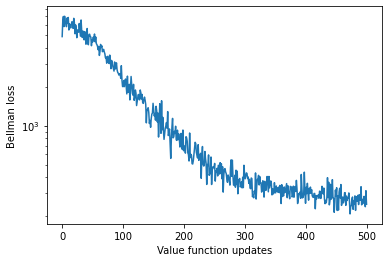

In [8]:

plt.plot(bellman_loss)
plt.yscale('log')
plt.xlabel('Value function updates')
plt.ylabel('Bellman loss')

Text(0, 0.5, 'Bellman approximation of value function')

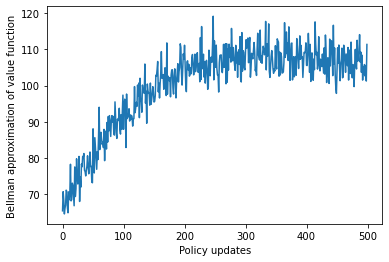

In [9]:
plt.plot(bellman_approx)
plt.xlabel('Policy updates')
plt.ylabel('Bellman approximation of value function')

## Plots value function

In [10]:
x1, x2 = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
y1, y2 = np.meshgrid(x1,x2)
x0 = torch.from_numpy(np.c_[y1.flatten(), y2.flatten()]).float()
v = lqr.v(x0).reshape(100,100).detach().numpy()

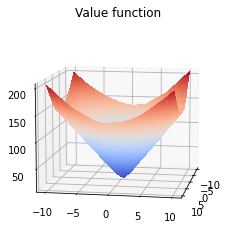

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(y1, y2, v, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.view_init(10, 10)
plt.title("Value function")
plt.show()

#fig.colorbar(surf, shrink=0.5, aspect=5)
#fig.tight_layout()
#plt.show()

Sample plot in 2d seen from above

Text(0, 0.5, '$x^2_0$')

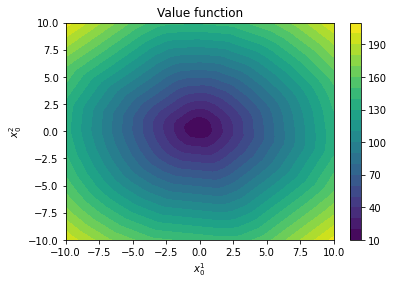

In [12]:
plt.contourf(y1,y2,v, levels=20)
plt.colorbar()
plt.title('Value function')
plt.xlabel(r'$x^1_0$')
plt.ylabel(r'$x^2_0$')

## Plots policy

In [13]:
x1, x2 = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
y1, y2 = np.meshgrid(x1,x2)
n_batch = 100*100

x = torch.from_numpy(np.c_[y1.flatten(), y2.flatten()]).float()
x_mc = torch.repeat_interleave(x, n_mc, dim=0) # (n_mc * n_batch, d)
z = torch.randn(n_mc*n_batch, 1, device=x.device) # input noise for the policy generator
with torch.no_grad():
    a = lqr.alpha(x_mc, z).reshape(n_batch, n_mc, -1).mean(1)
print(a.shape)


torch.Size([10000, 2])


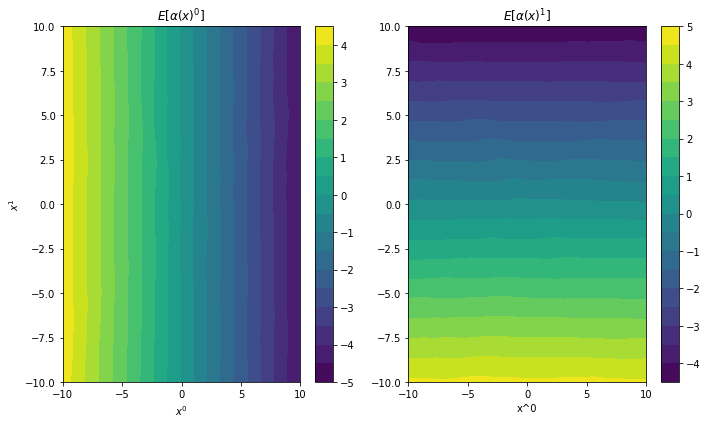

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

ax0 = ax[0].contourf(y1,y2,a[:,0].reshape(100,100), levels=20)
ax[0].set_title(r'$E [\alpha(x)^0]$')
ax[0].set_xlabel(r'$x^0$')
ax[0].set_ylabel(r'$x^1$')
plt.colorbar(ax0, ax=ax[0])
ax1 = ax[1].contourf(y1,y2,a[:,1].reshape(100,100), levels=20)
ax[1].set_title(r'$E[\alpha(x)^1]$')
ax[1].set_xlabel(r'x^0')
plt.colorbar(ax1, ax=ax[1])
fig.tight_layout()

